In [ ]:
# Import the neccessary packages
import networkx as nx
from matplotlib import pyplot as plt # import matplotlib
import numpy as np
import random
from tqdm import tqdm

In [ ]:
random.seed(12)

# **Simulated network**

In [ ]:
# Adapted ER
def core_periphery_network(core_size, periphery_size, p_core, p_periphery, p_between):
    # Create an empty graph
    G = nx.Graph()

    # Add core nodes
    core_nodes = range(core_size)
    G.add_nodes_from(core_nodes)

    # Add periphery nodes
    periphery_nodes = range(core_size, core_size + periphery_size)
    G.add_nodes_from(periphery_nodes)

    # Add edges within the core
    for i in core_nodes:
        for j in core_nodes:
            if i < j and np.random.rand() < p_core:
                G.add_edge(i, j)

    # Add edges within the periphery
    for i in periphery_nodes:
        for j in periphery_nodes:
            if i < j and np.random.rand() < p_periphery:
                G.add_edge(i, j)

    # Add edges between core and periphery
    for i in core_nodes:
        for j in periphery_nodes:
            if np.random.rand() < p_between:
                G.add_edge(i, j)

    return G

In [ ]:
# Parameters
core_size = 130            # Number of core nodes
periphery_size = 50       # Number of periphery nodes
p_core = 0.5              # Probability of edge within core
p_periphery = 0.05        # Probability of edge within periphery
p_between = 0.2          # Probability of edge between core and periphery

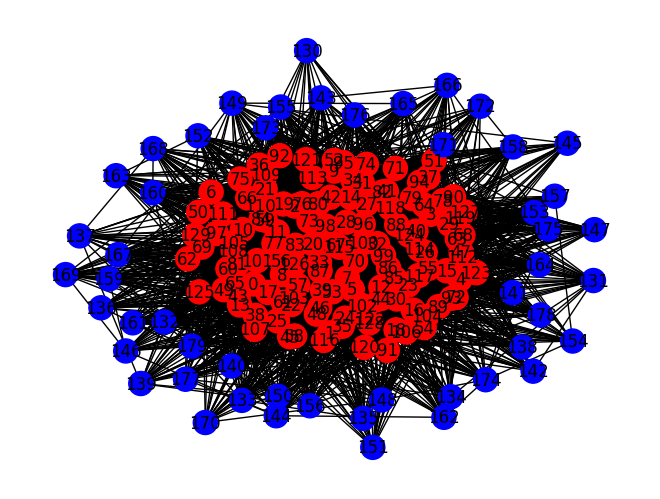

In [ ]:
# Generate the network
G = core_periphery_network(core_size, periphery_size, p_core, p_periphery, p_between)

# Draw the network
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color=['red' if i < core_size else 'blue' for i in G.nodes()])
plt.show()

# **Degree centrality**

Strategy:

1 step: onion-like core

2 step: periphery to core

In [ ]:
def schneider_robustness_index(G, centrality_func=nx.degree_centrality): # Compute the Schneider robustness index of the graph G using simultaneous node removal.
    G_copy = G.copy()  # Create a copy to avoid modifying the original graph
    num_nodes = G_copy.number_of_nodes()

    # Initialize robustness measure
    robustness_measure = 0

    # Initial computation of centrality
    centrality = centrality_func(G_copy)

    # Sort nodes by centrality
    sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)

    for node in sorted_nodes:
      # Remove node with highest importance
      G_copy.remove_node(node)

      # Compute the size of the largest connected component
      if G_copy.number_of_nodes() > 0:
        largest_component_size = len(max(nx.connected_components(G_copy), key=len))
      else:
        largest_component_size = 0

      # Add to robustness measure
      robustness_measure += largest_component_size / (num_nodes - 1)

    # Normalize the robustness measure
    robustness_index = robustness_measure / num_nodes

    return robustness_index

In [ ]:
def schneider_robustness_index2(G, centrality_func=nx.degree_centrality): # Compute the Schneider robustness index of the graph G using sequential node removal.
    G_copy = G.copy()  # Create a copy to avoid modifying the original graph
    num_nodes = G_copy.number_of_nodes()

    # Initialize robustness measure
    robustness_measure = 0

    for _ in range(num_nodes):
      # Initial computation of centrality
      centrality = centrality_func(G_copy)

      # Sort nodes by importance
      sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)

      # Remove node with highest importance
      G_copy.remove_node(sorted_nodes[0])

      # Compute the size of the largest connected component
      if G_copy.number_of_nodes() > 0:
        largest_component_size = len(max(nx.connected_components(G_copy), key=len))
      else:
        largest_component_size = 0

      # Add to robustness measure
      robustness_measure += largest_component_size / (num_nodes - 1)

    # Normalize the robustness measure
    robustness_index = robustness_measure / num_nodes

    return robustness_index

In [ ]:
def get_core_edges(G_copy, core_nodes):
    return [edge for edge in G_copy.edges(core_nodes) if edge[1] in core_nodes]

In [ ]:
def onion_core(G,core_size,n_iterations,centrality_func=nx.degree_centrality):
  G_copy=G.copy()
  core_nodes = set(range(core_size))
  current_robustness = schneider_robustness_index(G_copy,centrality_func)
  for i in range(n_iterations):
    centrality = centrality_func(G_copy)
    core_edges = get_core_edges(G_copy, core_nodes)
    edge_1, edge_2 = random.sample(core_edges, 2)
    if len(set(edge_1).intersection(set(edge_2)))==0:
      # Sort sample nodes based on centrality
      sampled_nodes = [edge_1[0],edge_1[1],edge_2[0],edge_2[1]]
      sampled_nodes.sort(key=lambda x: centrality[x], reverse=True)
      pairs = [(sampled_nodes[0], sampled_nodes[1]), (sampled_nodes[2], sampled_nodes[3])]
      # Check if there are no multiedges
      if not (G_copy.has_edge(pairs[0][0],pairs[0][1]) or G_copy.has_edge(pairs[1][0],pairs[1][1])):
        # Add new edges
        G_copy.add_edge(pairs[0][0],pairs[0][1])
        G_copy.add_edge(pairs[1][0],pairs[1][1])
        # Remove old edges
        G_copy.remove_edge(edge_1[0],edge_1[1])
        G_copy.remove_edge(edge_2[0],edge_2[1])
        # Revert change if robustness did not improve
        new_robustness = schneider_robustness_index(G_copy,centrality_func)
        if current_robustness > new_robustness:
          G_copy.remove_edge(pairs[0][0],pairs[0][1])
          G_copy.remove_edge(pairs[1][0],pairs[1][1])
          G_copy.add_edge(edge_1[0],edge_1[1])
          G_copy.add_edge(edge_2[0],edge_2[1])
        else:
          current_robustness = new_robustness
          #print(i)
  return G_copy

In [ ]:
def swap_edges(G, e_mn, e_jk):
    # Remove edges
    G.remove_edge(*e_mn)
    G.remove_edge(*e_jk)

    # Add new edges
    G.add_edge(e_mn[0], e_jk[1])
    G.add_edge(e_jk[0], e_mn[1])

    edge1 = (e_mn[0], e_jk[1])
    edge2 = (e_jk[0], e_mn[1])

    return edge1, edge2

We can compare robustness already after only chages in core.

Otherwise we can also change connections between core and periphery. In particular, we make core nodes with high importance only connect with core nodes, and connections between core and periphery have to happen with core nodes of low importance

In [ ]:
def between_core_periphery_edge_rewiring(G,core_size,n_iterations,centrality_func=nx.degree_centrality):
  G_copy=G.copy()
  core_nodes = list(range(core_size))
  for i in range(n_iterations):
    centrality = centrality_func(G_copy)
    core_nodes.sort(key=lambda x: centrality[x], reverse=True)
    core_periphery_edges = [edge for edge in G_copy.edges(core_nodes) if not (edge[1] in core_nodes)] # ordered based on order of nodes in core_nodes
    p = [np.sqrt(centrality[edge[0]]) for edge in core_periphery_edges] #sqrt to increase likelihood of choosing nodes with higher weights
    edge_1 = random.choices(core_periphery_edges,k=1,weights=p)[0]
    core_edges = [edge for edge in G_copy.edges(core_nodes) if edge[1] in core_nodes]
    # in other_core_edges consider only nodes that have lower degree centrality
    # than core node of edge_1
    other_core_edges = [edge for edge in core_edges if centrality[edge_1[0]]>=centrality[edge[0]] and centrality[edge_1[0]]>=centrality[edge[1]] and not (edge_1[0] in edge)]
    if len(other_core_edges)==0:
      continue
    p1 = [max(1/centrality[edge[0]],1/centrality[edge[1]])**2 for edge in other_core_edges] # prefer core nodes with low importance, ^2 to increase distance
    edge_2 = tuple(sorted(random.choices(other_core_edges,k=1,weights=p1)[0],key=lambda x: centrality[x], reverse=True)) # sample core edge and sort tuple so that the one with higher importance is first
    node_2_edges = [edge for edge in G_copy.edges(edge_2[1]) if edge[1] in core_nodes]
    if len(node_2_edges)<=1:
      continue
    if not (G_copy.has_edge(edge_1[0],edge_2[0]) or G_copy.has_edge(edge_1[1],edge_2[1])):
      # Add new edges
      G_copy.add_edge(edge_1[0],edge_2[0])
      G_copy.add_edge(edge_1[1],edge_2[1])
      # Remove old edges
      G_copy.remove_edge(edge_1[0],edge_1[1])
      G_copy.remove_edge(edge_2[0],edge_2[1])
      #print(i)
  return G_copy

We finally define our algorithm to increase robustness with edge rewiring, we use both functions previously defined and combine them:

In [ ]:
def robustness_edge_rewiring(G,core_size,n_steps,n_iterations_function_1,n_iterations_function_2,centrality_func=nx.degree_centrality):
  G_copy=G.copy()
  for i in tqdm(range(n_steps)):
    if i%2==0:
      G_copy = between_core_periphery_edge_rewiring(G_copy,core_size,n_iterations_function_1,centrality_func)
    else:
      G_copy = onion_core(G_copy,core_size,n_iterations_function_2,centrality_func)
  return G_copy

In [ ]:
# new parameters
core_size_1 = 100            # Number of core nodes
periphery_size_1 = 100       # Number of periphery nodes
p_core_1 = 0.7              # Probability of edge within core
p_periphery_1 = 0.01        # Probability of edge within periphery
p_between_1 = 0.1          # Probability of edge between core and periphery

In [ ]:
G4 = core_periphery_network(core_size_1, periphery_size_1, p_core_1, p_periphery_1, p_between_1)

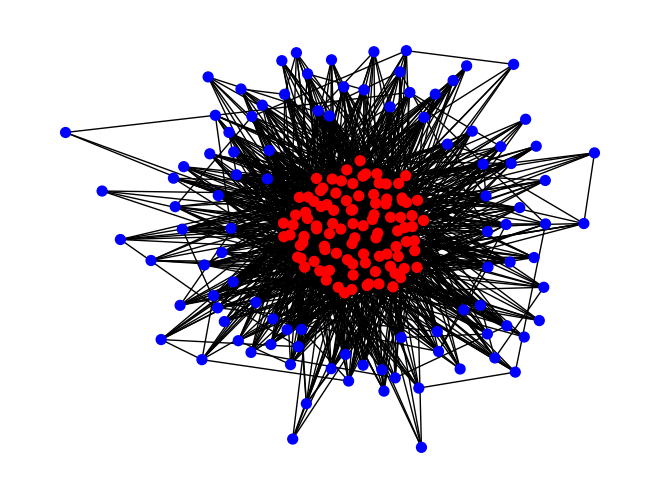

In [ ]:
# Draw the network
pos4 = nx.spring_layout(G4)
nx.draw(G4, pos4, with_labels=False,node_size=50, node_color=['red' if i < core_size_1 else 'blue' for i in G4.nodes()])
plt.show()

In [ ]:
G5 = robustness_edge_rewiring(G4,core_size_1,2,2000,2000)

100%|██████████| 2/2 [00:36<00:00, 18.00s/it]


In [ ]:
G6 = onion_core(G4,core_size_1,2000)

In [ ]:
G7 = between_core_periphery_edge_rewiring(G4,core_size_1,2000)

Borgatti everett score in tranformed networks:

In [ ]:
def borgatti_everett_score(G,core_size,periphery_size):
  A = nx.adjacency_matrix(G)
  p = 2*G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))
  return (A[core_size:core_size + periphery_size, core_size:core_size + periphery_size].sum()-p)/2

In [ ]:
print("5: ", borgatti_everett_score(G5,core_size_1,periphery_size_1))
print("6: ", borgatti_everett_score(G6,core_size_1,periphery_size_1))
print("7: ", borgatti_everett_score(G7,core_size_1,periphery_size_1))
print("9: ", borgatti_everett_score(G9,core_size_1,periphery_size_1))

5:  35.86773869346734
6:  35.86773869346734
7:  35.86773869346734
9:  35.86773869346734


## Robustness check:

In [ ]:
def robustness(G, centrality_func): # Compute the Schneider robustness index of the graph G using simultanoeus node removal.
    G_copy = G.copy()  # Create a copy to avoid modifying the original graph
    num_nodes = G_copy.number_of_nodes()

    # Initialize robustness measure
    robustness_measure = [len(max(nx.connected_components(G_copy), key=len))/(num_nodes - 1)]

    # Initial computation of centrality
    centrality = centrality_func(G_copy)

    # Sort nodes by centrality
    sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)

    # Iterate through nodes in decreasing order of centrality
    for node in sorted_nodes:
      # Remove node with highest importance
      G_copy.remove_node(node)

      # Compute the size of the largest connected component
      if G_copy.number_of_nodes() > 0:
        largest_component_size = len(max(nx.connected_components(G_copy), key=len))/(num_nodes - 1)
      else:
        largest_component_size = 0

      # Add to robustness measure
      robustness_measure.append(largest_component_size)

    return robustness_measure

In [ ]:
def robustness2(G, centrality_func): # Compute the Schneider robustness index of the graph G using sequential node removal.
    G_copy = G.copy()  # Create a copy to avoid modifying the original graph
    num_nodes = G_copy.number_of_nodes()

    # Initialize robustness measure
    robustness_measure = [len(max(nx.connected_components(G_copy), key=len))/(num_nodes - 1)]

    for _ in range(num_nodes):
      # Compute importance of nodes
      centrality = centrality_func(G_copy)

      # Sort nodes by importance
      sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)

      # Remove node with highest importance
      G_copy.remove_node(sorted_nodes[0])

      # Compute the size of the largest connected component
      if G_copy.number_of_nodes() > 0:
        largest_component_size = len(max(nx.connected_components(G_copy), key=len))/(num_nodes - 1)
      else:
        largest_component_size = 0

      # Add to robustness measure
      robustness_measure.append(largest_component_size)

    return robustness_measure

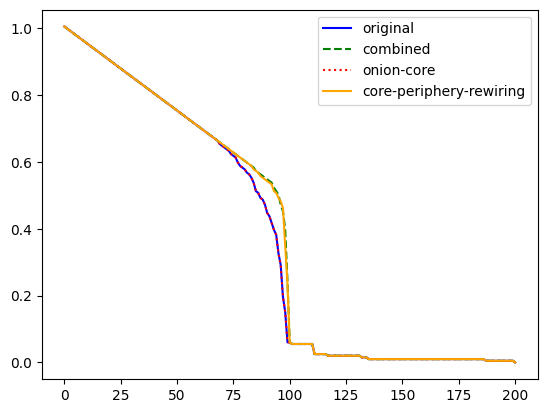

In [ ]:
# degree centrality
r4 = robustness(G4,nx.degree_centrality)
r5 = robustness(G5,nx.degree_centrality)
r6 = robustness(G6,nx.degree_centrality)
r7 = robustness(G7,nx.degree_centrality)
plt.plot(r4,color='blue', linestyle='-',label='original')
plt.plot(r5,color='green',linestyle='--',label='combined')
plt.plot(r6,color='red',linestyle=':',label='onion-core')
plt.plot(r7,color='orange',linestyle='-',label='core-periphery-rewiring')
plt.legend()
plt.show()

In [ ]:
# closeness centrality
G5_closeness = robustness_edge_rewiring(G4,core_size_1,2,2000,2000,nx.closeness_centrality)
G6_closeness = onion_core(G4,core_size_1,2000,nx.closeness_centrality)
G7_closeness = between_core_periphery_edge_rewiring(G4,core_size_1,2000,nx.closeness_centrality)

100%|██████████| 2/2 [03:02<00:00, 91.25s/it]


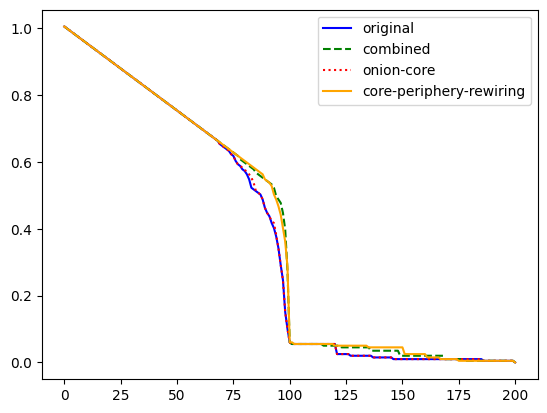

In [ ]:
r4_closeness = robustness(G4,nx.closeness_centrality)
r5_closeness = robustness(G5_closeness,nx.closeness_centrality)
r6_closeness = robustness(G6_closeness,nx.closeness_centrality)
r7_closeness = robustness(G7_closeness,nx.closeness_centrality)
plt.plot(r4_closeness,color='blue', linestyle='-',label='original')
plt.plot(r5_closeness,color='green',linestyle='--',label='combined')
plt.plot(r6_closeness,color='red',linestyle=':',label='onion-core')
plt.plot(r7_closeness,color='orange',linestyle='-',label='core-periphery-rewiring')
plt.legend()
plt.show()

In [ ]:
# eigenvector centrality
G5_eigenvector = robustness_edge_rewiring(G4,core_size_1,2,2000,2000,nx.eigenvector_centrality)
G6_eigenvector = onion_core(G4,core_size_1,2000,nx.eigenvector_centrality)
G7_eigenvector = between_core_periphery_edge_rewiring(G4,core_size_1,2000,nx.eigenvector_centrality)

100%|██████████| 2/2 [01:23<00:00, 41.51s/it]


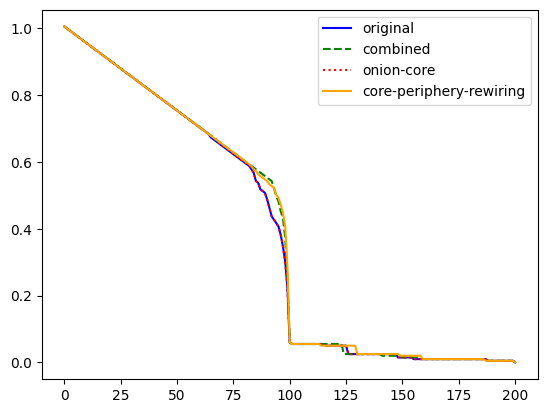

In [ ]:
r4_eigenvector = robustness(G4,nx.eigenvector_centrality)
r5_eigenvector = robustness(G5_eigenvector,nx.eigenvector_centrality)
r6_eigenvector = robustness(G6_eigenvector,nx.eigenvector_centrality)
r7_eigenvector = robustness(G7_eigenvector,nx.eigenvector_centrality)
plt.plot(r4_eigenvector,color='blue', linestyle='-',label='original')
plt.plot(r5_eigenvector,color='green',linestyle='--',label='combined')
plt.plot(r6_eigenvector,color='red',linestyle=':',label='onion-core')
plt.plot(r7_eigenvector,color='orange',linestyle='-',label='core-periphery-rewiring')
plt.legend()
plt.show()

### Sequential

In [ ]:
def onion_core2(G,core_size,n_iterations,centrality_func=nx.degree_centrality): # I put 2 as a suffix for all functions related to sequential robustness
  G_copy=G.copy()
  core_nodes = set(range(core_size))
  current_robustness = schneider_robustness_index2(G_copy,centrality_func)
  for i in range(n_iterations):
    centrality = centrality_func(G_copy)
    core_edges = get_core_edges(G_copy, core_nodes)
    edge_1, edge_2 = random.sample(core_edges, 2)
    if len(set(edge_1).intersection(set(edge_2)))==0:
      # Sort sample nodes based on centrality
      sampled_nodes = [edge_1[0],edge_1[1],edge_2[0],edge_2[1]]
      sampled_nodes.sort(key=lambda x: centrality[x], reverse=True)
      pairs = [(sampled_nodes[0], sampled_nodes[1]), (sampled_nodes[2], sampled_nodes[3])]
      # Check if there are no multiedges
      if not (G_copy.has_edge(pairs[0][0],pairs[0][1]) or G_copy.has_edge(pairs[1][0],pairs[1][1])):
        # Add new edges
        G_copy.add_edge(pairs[0][0],pairs[0][1])
        G_copy.add_edge(pairs[1][0],pairs[1][1])
        # Remove old edges
        G_copy.remove_edge(edge_1[0],edge_1[1])
        G_copy.remove_edge(edge_2[0],edge_2[1])
        # Revert change if robustness did not improve
        new_robustness = schneider_robustness_index(G_copy,centrality_func)
        if current_robustness > new_robustness:
          G_copy.remove_edge(pairs[0][0],pairs[0][1])
          G_copy.remove_edge(pairs[1][0],pairs[1][1])
          G_copy.add_edge(edge_1[0],edge_1[1])
          G_copy.add_edge(edge_2[0],edge_2[1])
        else:
          current_robustness = new_robustness
          #print(i)
  return G_copy

In [ ]:
def robustness_edge_rewiring2(G,core_size,n_steps,n_iterations_function_1,n_iterations_function_2,centrality_func=nx.degree_centrality):
  G_copy=G.copy()
  for i in tqdm(range(n_steps)):
    if i%2==0:
      G_copy = between_core_periphery_edge_rewiring(G_copy,core_size,n_iterations_function_1,centrality_func)
    else:
      G_copy = onion_core2(G_copy,core_size,n_iterations_function_2,centrality_func)
  return G_copy

In [ ]:
# degree centrality
G5_seq = robustness_edge_rewiring2(G4,core_size_1,2,2000,2000,nx.degree_centrality)
G6_seq = onion_core2(G4,core_size_1,2000,nx.degree_centrality)

100%|██████████| 2/2 [00:35<00:00, 17.98s/it]


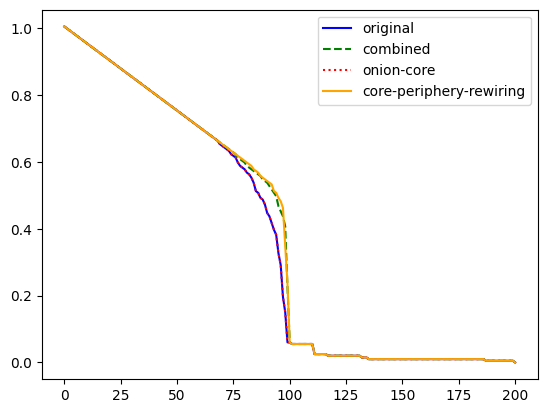

In [ ]:
# degree centrality
r4_seq = robustness(G4,nx.degree_centrality) # same network as above
r5_seq = robustness(G5_seq,nx.degree_centrality)
r6_seq = robustness(G6_seq,nx.degree_centrality)
r7_seq = robustness(G7,nx.degree_centrality) # same network as above
plt.plot(r4_seq,color='blue', linestyle='-',label='original')
plt.plot(r5_seq,color='green',linestyle='--',label='combined')
plt.plot(r6_seq,color='red',linestyle=':',label='onion-core')
plt.plot(r7_seq,color='orange',linestyle='-',label='core-periphery-rewiring')
plt.legend()
plt.show()

In [ ]:
# closeness centrality
G5_seq_closeness = robustness_edge_rewiring2(G4,core_size_1,2,2000,2000,nx.closeness_centrality)
G6_seq_closeness = onion_core2(G4,core_size_1,2000,nx.closeness_centrality)

100%|██████████| 2/2 [02:51<00:00, 85.53s/it]


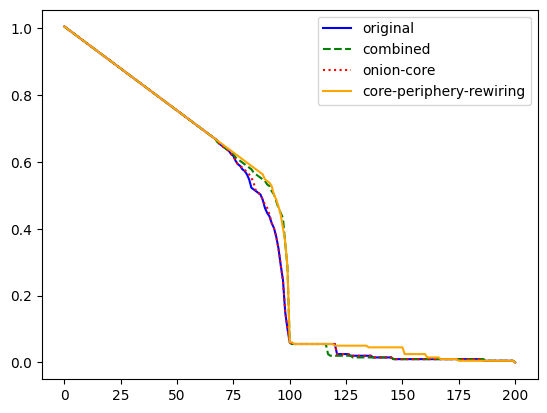

In [ ]:
r4_seq_closeness = robustness(G4,nx.closeness_centrality)
r5_seq_closeness = robustness(G5_seq_closeness,nx.closeness_centrality)
r6_seq_closeness = robustness(G6_seq_closeness,nx.closeness_centrality)
r7_seq_closeness = robustness(G7_closeness,nx.closeness_centrality)
plt.plot(r4_seq_closeness,color='blue', linestyle='-',label='original')
plt.plot(r5_seq_closeness,color='green',linestyle='--',label='combined')
plt.plot(r6_seq_closeness,color='red',linestyle=':',label='onion-core')
plt.plot(r7_seq_closeness,color='orange',linestyle='-',label='core-periphery-rewiring')
plt.legend()
plt.show()

<ipython-input-74-6de2d192e9fc>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


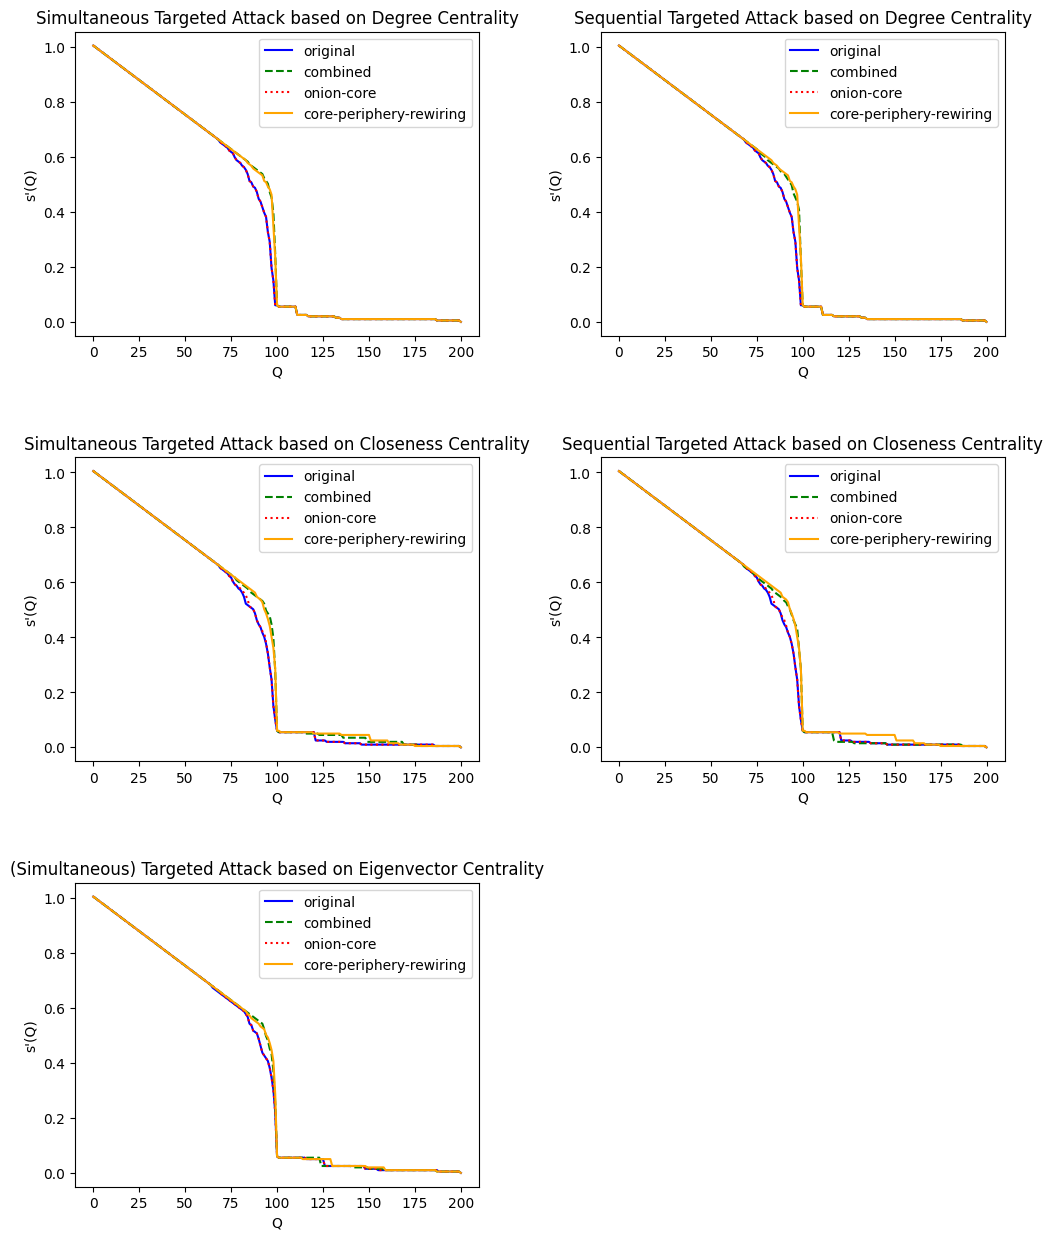

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# Set labels
x_label = 'Q'
y_label = "s'(Q)"

# Simultaneous Degree Centrality
axs[0, 0].plot(r4, color='blue', linestyle='-', label='original')
axs[0, 0].plot(r5, color='green', linestyle='--', label='combined')
axs[0, 0].plot(r6, color='red', linestyle=':', label='onion-core')
axs[0, 0].plot(r7, color='orange', linestyle='-', label='core-periphery-rewiring')
axs[0, 0].set_title('Simultaneous Targeted Attack based on Degree Centrality')
axs[0, 0].set_xlabel(x_label)
axs[0, 0].set_ylabel(y_label)
axs[0, 0].legend()

# Sequential Degree Centrality
axs[0, 1].plot(r4_seq, color='blue', linestyle='-', label='original')
axs[0, 1].plot(r5_seq, color='green', linestyle='--', label='combined')
axs[0, 1].plot(r6_seq, color='red', linestyle=':', label='onion-core')
axs[0, 1].plot(r7_seq, color='orange', linestyle='-', label='core-periphery-rewiring')
axs[0, 1].set_title('Sequential Targeted Attack based on Degree Centrality')
axs[0, 1].set_xlabel(x_label)
axs[0, 1].set_ylabel(y_label)
axs[0, 1].legend()

# Simultaneous Closeness Centrality
axs[1, 0].plot(r4_closeness, color='blue', linestyle='-', label='original')
axs[1, 0].plot(r5_closeness, color='green', linestyle='--', label='combined')
axs[1, 0].plot(r6_closeness, color='red', linestyle=':', label='onion-core')
axs[1, 0].plot(r7_closeness, color='orange', linestyle='-', label='core-periphery-rewiring')
axs[1, 0].set_title('Simultaneous Targeted Attack based on Closeness Centrality')
axs[1, 0].set_xlabel(x_label)
axs[1, 0].set_ylabel(y_label)
axs[1, 0].legend()

# Sequential Closeness Centrality
axs[1, 1].plot(r4_seq_closeness, color='blue', linestyle='-', label='original')
axs[1, 1].plot(r5_seq_closeness, color='green', linestyle='--', label='combined')
axs[1, 1].plot(r6_seq_closeness, color='red', linestyle=':', label='onion-core')
axs[1, 1].plot(r7_seq_closeness, color='orange', linestyle='-', label='core-periphery-rewiring')
axs[1, 1].set_title('Sequential Targeted Attack based on Closeness Centrality')
axs[1, 1].set_xlabel(x_label)
axs[1, 1].set_ylabel(y_label)
axs[1, 1].legend()

# Simultaneous Eigenvector Centrality
axs[2, 0].plot(r4_eigenvector, color='blue', linestyle='-', label='original')
axs[2, 0].plot(r5_eigenvector, color='green', linestyle='--', label='combined')
axs[2, 0].plot(r6_eigenvector, color='red', linestyle=':', label='onion-core')
axs[2, 0].plot(r7_eigenvector, color='orange', linestyle='-', label='core-periphery-rewiring')
axs[2, 0].set_title('(Simultaneous) Targeted Attack based on Eigenvector Centrality')
axs[2, 0].set_xlabel(x_label)
axs[2, 0].set_ylabel(y_label)
axs[2, 0].legend()


axs[2, 1].axis('off')

# Save the figure
plt.tight_layout()
plt.savefig('/content/network_robustness_plots.png')
plt.show()

In [ ]:
from google.colab import files
files.download('/content/network_robustness_plots.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Betweenness centrality**

Previous strategy works badly for betweenness centrality, as rewiring edges between core and periphery and concentrating them in a smaller numer of core nodes will boost betweenness centrality of these nodes, and they will be among the first to be targeted, in this way, the largest connected component loses not only the nodes that are targeted but, with high probability, also the nodes in the periphery that are connected to the targeted core nodes.

Strategy:

Edge rewiring based on edge betweenness centrality


By rewiring edges with a high importance, we directly address nodes that have high betweenness centrality. These edges and nodes are highly connect different parts of the network.

In [ ]:
def betweenness_edge_rewiring(G,core_size,n_iterations):
  G_copy=G.copy()
  core_nodes = list(range(core_size))
  for i in range(n_iterations):
    betweenness_centrality = nx.edge_betweenness_centrality(G_copy)
    # select only edges in core
    core_edges = [edge for edge in G_copy.edges(core_nodes) if edge[1] in core_nodes]
    # sort edges based on betweenness centrality
    core_edges.sort(key=lambda x: betweenness_centrality[x], reverse=True)
    # select core edge with highest importance
    edge_1 = core_edges[0]
    # select other core edges with low importance
    other_core_edges = [edge for edge in core_edges if not (edge_1[0] in edge or edge_1[1] in edge)]
    if len(other_core_edges)==0:
      continue
    weights = [1/(betweenness_centrality[edge]+0.0001) for edge in other_core_edges] # add +0.0001 to avoid division by 0
    edge_2 = random.choices(other_core_edges,k=1,weights=weights)[0]
    # check if no multiedges and perform switch
    if (G_copy.has_edge(edge_1[0],edge_2[1]) or G_copy.has_edge(edge_1[1],edge_2[0])) and not (G_copy.has_edge(edge_1[0],edge_2[0]) or G_copy.has_edge(edge_1[1],edge_2[1])):
      # Add new edges
      G_copy.add_edge(edge_1[0],edge_2[0])
      G_copy.add_edge(edge_1[1],edge_2[1])
      # Remove old edges
      G_copy.remove_edge(edge_1[0],edge_1[1])
      G_copy.remove_edge(edge_2[0],edge_2[1])
      #print(i)
    if not (G_copy.has_edge(edge_1[0],edge_2[1]) or G_copy.has_edge(edge_1[1],edge_2[0])) and (G_copy.has_edge(edge_1[0],edge_2[0]) or G_copy.has_edge(edge_1[1],edge_2[1])):
      # Add new edges
      G_copy.add_edge(edge_1[0],edge_2[1])
      G_copy.add_edge(edge_1[1],edge_2[0])
      # Remove old edges
      G_copy.remove_edge(edge_1[0],edge_1[1])
      G_copy.remove_edge(edge_2[0],edge_2[1])
      #print(i)
    if not (G_copy.has_edge(edge_1[0],edge_2[1]) or G_copy.has_edge(edge_1[1],edge_2[0])) and not (G_copy.has_edge(edge_1[0],edge_2[0]) or G_copy.has_edge(edge_1[1],edge_2[1])):
      # Remove old edges
      G_copy.remove_edge(edge_1[0],edge_1[1])
      G_copy.remove_edge(edge_2[0],edge_2[1])
      if random.random() < 0.5:
        # Add new edges
        G_copy.add_edge(edge_1[0],edge_2[0])
        G_copy.add_edge(edge_1[1],edge_2[1])
      else:
        # Add new edges
        G_copy.add_edge(edge_1[0],edge_2[1])
        G_copy.add_edge(edge_1[1],edge_2[0])
      #print(i)
  return G_copy

In [ ]:
G8 = betweenness_edge_rewiring(G4,core_size_1,100)

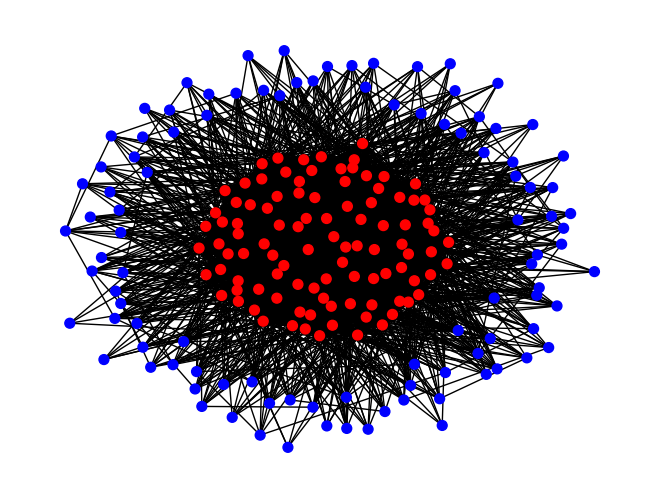

In [ ]:
pos8 = nx.kamada_kawai_layout(G8)
nx.draw(G8, pos8, with_labels=False,node_size=50, node_color=['red' if i < core_size_1 else 'blue' for i in G8.nodes()])
plt.show()

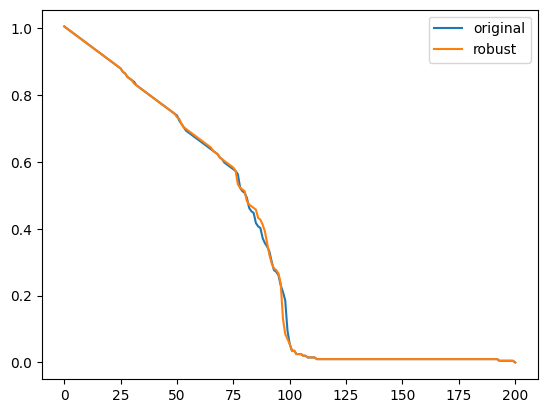

In [ ]:
r4 = robustness2(G4,nx.betweenness_centrality)
r8 = robustness2(G8,nx.betweenness_centrality)
plt.plot(r4)
plt.plot(r8)
plt.legend(['original','robust'])
plt.show()

Edge rewiring only in core is not enough, as betweenness centrality scores are mainly made by connections between peripherial nodes, as nodes in the core are all close to each other.
Therefore, we should work on edges between core and periphery.

In [ ]:
def between_core_periphery_edge_rewiring_betweenness(G,core_size,n_iterations):
  G_copy=G.copy()
  core_nodes = list(range(core_size))
  for _ in tqdm(range(n_iterations)):
    # update the centrality values
    centrality = nx.betweenness_centrality(G_copy)
    # sort core nodes based on centrality
    sorted_nodes = core_nodes.copy()
    sorted_nodes.sort(key=lambda x: centrality[x], reverse=True)
    node_1 = sorted_nodes[0]
    # update weights
    # prev strat: weight_1 = [np.sqrt(centrality[x]) for x in core_nodes]
    weight_2 = [(1/(centrality[x]+0.001))**2 for x in core_nodes] # +0.001 to avoid division by 0
    # select core edge with highest importance and one with low importance, use weights in random sampling
    # prev strat: node_1 = random.choices(core_nodes,k=1,weights=weight_1)[0]
    other_core_nodes = core_nodes.copy()
    other_core_nodes.remove(node_1)
    if not other_core_nodes:
      continue
    # remove weight related to node_1 in weight_2
    weight_2 = [weight for i, weight in enumerate(weight_2) if i != node_1]
    node_2 = random.choices(other_core_nodes,k=1,weights=weight_2)[0]
    # define list of edges from node_1 to periphery
    edge_node_1_to_periphery = [edge for edge in G_copy.edges(node_1) if not (edge[1] in core_nodes)]
    # define list of edges from node_2 to core except node_1
    edge_node_2_to_core = [edge for edge in G_copy.edges(node_2) if edge[1] in core_nodes and edge[1]!=node_1]
    if len(edge_node_1_to_periphery)==0 or len(edge_node_2_to_core)==0:
      continue
    edge_1 = random.choice(edge_node_1_to_periphery)
    edge_2 = random.choice(edge_node_2_to_core)
    r = schneider_robustness_index(G_copy, nx.betweenness_centrality)
    if not (G_copy.has_edge(edge_1[0],edge_2[1]) or G_copy.has_edge(edge_2[0],edge_1[1])):
      # Swap edges
      edge_1, edge_2 = swap_edges(G_copy, edge_1, edge_2)
      if r > schneider_robustness_index(G_copy, nx.betweenness_centrality):
        # Revert the change if robustness did not improve
        swap_edges(G_copy, edge_1, edge_2)
        continue
      #else:
        #print(".")
  return G_copy

In [ ]:
# new parameters
core_size_2 = 100            # Number of core nodes
periphery_size_2 = 100       # Number of periphery nodes
p_core_2 = 0.6              # Probability of edge within core
p_periphery_2 = 0.01        # Probability of edge within periphery
p_between_2 = 0.1          # Probability of edge between core and periphery

In [ ]:
G10 = core_periphery_network(core_size_2, periphery_size_2, p_core_2, p_periphery_2, p_between_2)

In [ ]:
G11 = between_core_periphery_edge_rewiring_betweenness(G10,core_size_2,100)

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


In [ ]:
G13 = between_core_periphery_edge_rewiring(G10,core_size_2,200,nx.betweenness_centrality)

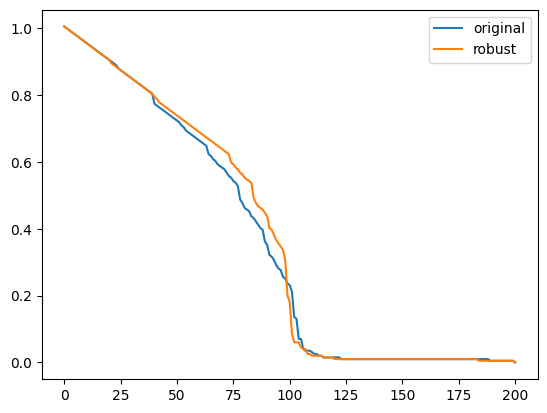

In [ ]:
r10 = robustness2(G10,nx.betweenness_centrality)
r13 = robustness2(G13,nx.betweenness_centrality)
plt.plot(r10)
plt.plot(r13)
plt.legend(['original','robust'])
plt.show()

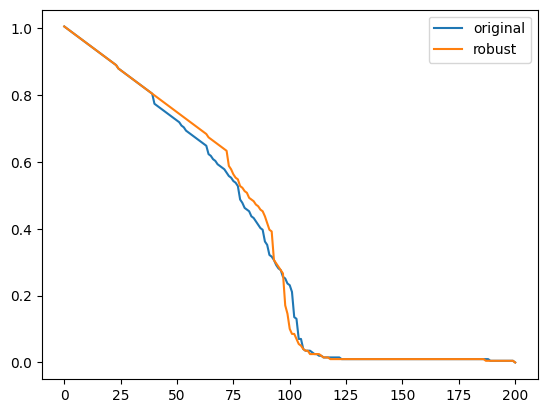

In [ ]:
r11 = robustness2(G11,nx.betweenness_centrality)
plt.plot(r10)
plt.plot(r11)
plt.legend(['original','robust'])
plt.show()

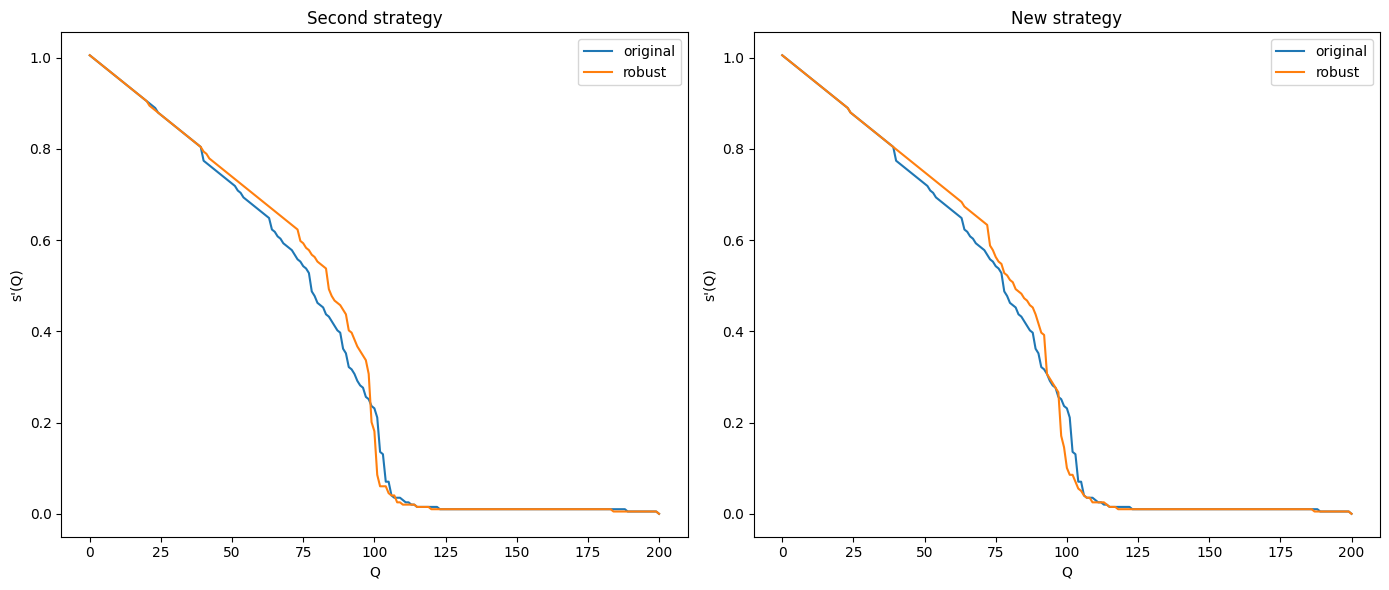

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot on the first subplot
axs[0].plot(r10, label='original')
axs[0].plot(r13, label='robust')
axs[0].legend()
axs[0].set_title('Second strategy')
axs[0].set_xlabel('Q')
axs[0].set_ylabel('s\'(Q)')

# Plot on the second subplot
axs[1].plot(r10, label='original')
axs[1].plot(r11, label='robust')
axs[1].legend()
axs[1].set_title('New strategy')
axs[1].set_xlabel('Q')
axs[1].set_ylabel('s\'(Q)')

# Adjust layout
plt.tight_layout()

# Save the figure
fig.savefig('/content/plots_betweenness.png')  # Save the figure to a file

# Show the figure
plt.show()

files.download('/content/plots_betweenness.png')

In core betweenness centr is similar in value in all nodes, so rewiring based and that value does not improve, there is no big difference in betweenness in all core nodes

In [ ]:
b = nx.betweenness_centrality(G10)
b

{0: 0.013967592734602857,
 1: 0.010531028387159845,
 2: 0.010606252704461111,
 3: 0.004424164771744154,
 4: 0.006154070002818716,
 5: 0.012530431156298398,
 6: 0.010188366360312413,
 7: 0.003484683320325512,
 8: 0.005786918710442556,
 9: 0.009857447328849873,
 10: 0.011241958590975027,
 11: 0.009157173807576144,
 12: 0.009723326322009215,
 13: 0.005534899909758048,
 14: 0.008534021414020376,
 15: 0.014737474280862053,
 16: 0.01087008758257598,
 17: 0.01433015155215947,
 18: 0.006713517421471896,
 19: 0.006960166315218609,
 20: 0.006808172851045594,
 21: 0.00571459293289486,
 22: 0.007775315942344806,
 23: 0.01402541352418309,
 24: 0.011566247475536797,
 25: 0.014158827539656612,
 26: 0.007177415117470579,
 27: 0.006403129567704231,
 28: 0.015382753682393252,
 29: 0.014007565454278692,
 30: 0.009561444175457035,
 31: 0.011406828744880778,
 32: 0.0061328519886949635,
 33: 0.005157574083482719,
 34: 0.008541776516791083,
 35: 0.006067618314397802,
 36: 0.009259835075636212,
 37: 0.0110574

In [ ]:
b1 = nx.betweenness_centrality(G11)
b1

{0: 0.005694441040865763,
 1: 0.013219989507300297,
 2: 0.009729217938059918,
 3: 0.007314589403849652,
 4: 0.008131911438766319,
 5: 0.008478423428925779,
 6: 0.0077420003385530786,
 7: 0.0057527942128304185,
 8: 0.010956619233529466,
 9: 0.005075577391839235,
 10: 0.012640909277049948,
 11: 0.008826929106401026,
 12: 0.01179989715510343,
 13: 0.008653122638750392,
 14: 0.008828969246366669,
 15: 0.007836389688474499,
 16: 0.010822589704778559,
 17: 0.01058978980094677,
 18: 0.00811206234608057,
 19: 0.009588349852395057,
 20: 0.006663137213291935,
 21: 0.008783661541269224,
 22: 0.008889383571904382,
 23: 0.007829930355401693,
 24: 0.010919495351656443,
 25: 0.009576690546526484,
 26: 0.0060638728793424345,
 27: 0.011500749630640078,
 28: 0.009076276148534856,
 29: 0.010845305464330499,
 30: 0.005851285628661245,
 31: 0.00689316989823371,
 32: 0.012504581142704483,
 33: 0.007685815869916717,
 34: 0.00540493482823232,
 35: 0.007018387095302527,
 36: 0.008115670473186624,
 37: 0.006535

# **Empirical part:**

In [ ]:
import pandas as pd

## 1: Telegram

In [ ]:
# Upload dataset
df = pd.read_csv('G1_2015-2019_edgelist.csv')

# Remove duplicates to prepare dataset for creating an undirected network
df[['source', 'target']] = df[['source', 'target']].apply(lambda row: pd.Series(sorted(row)), axis=1)
df_unique = df.drop_duplicates(subset=['source', 'target'])

In [ ]:
G = nx.from_pandas_edgelist(df_unique, source='source', target='target', edge_attr=True)

Method to define core and periphery:

In [ ]:
pip install cpnet

In [ ]:
import cpnet
algorithm = cpnet.KM_config()

In [ ]:
algorithm.detect(G)

In [ ]:
x = algorithm.get_coreness()

In [ ]:
# Separate nodes
core_nodes = [node for node, label in x.items() if label == 1]
periphery_nodes = [node for node, label in x.items() if label == 0]

# relabel nodes
core_size = len(core_nodes)
new_labels = {}

for i, node in enumerate(core_nodes):
    new_labels[node] = i

for i, node in enumerate(periphery_nodes, start=core_size):
    new_labels[node] = i

# new_label is a dict with keys = old labels, values = new labels

In [ ]:
print(core_size,len(periphery_nodes))

183 515


In [ ]:
G.number_of_nodes()

698

In [ ]:
G_copy = nx.relabel_nodes(G, new_labels)

In [ ]:
G_1 = onion_core2(G_copy,core_size,2000)

In [ ]:
G_2 = between_core_periphery_edge_rewiring(G_copy,core_size,2000)

In [ ]:
G_3 = robustness_edge_rewiring2(G_copy,core_size,2,2000,2000)

100%|██████████| 2/2 [00:40<00:00, 20.30s/it]


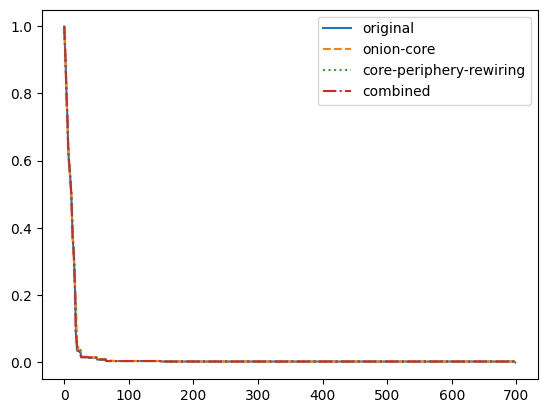

In [ ]:
# robustness
r = robustness(G_copy,nx.degree_centrality)
r_1 = robustness(G_1,nx.degree_centrality)
r_2 = robustness(G_2,nx.degree_centrality)
r_3 = robustness(G_3,nx.degree_centrality)
plt.plot(r,linestyle='-')
plt.plot(r_1,linestyle='--')
plt.plot(r_2,linestyle=':')
plt.plot(r_3,linestyle='-.')
plt.legend(['original','onion-core','core-periphery-rewiring','combined'])
plt.show()

In [ ]:
G_1_sim = onion_core(G_copy,core_size,2000)
G_2_sim = between_core_periphery_edge_rewiring(G_copy,core_size,2000)
G_3_sim = robustness_edge_rewiring(G_copy,core_size,2,2000,2000)

100%|██████████| 2/2 [00:22<00:00, 11.49s/it]


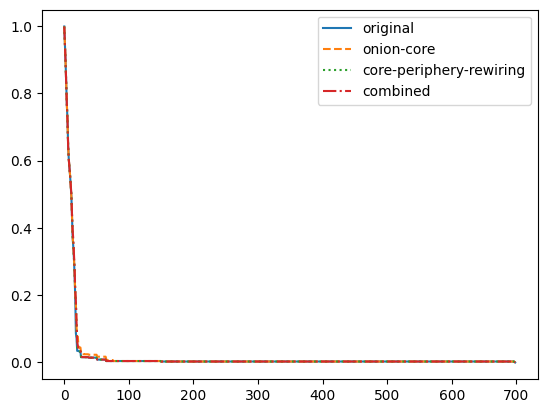

In [ ]:
# robustness
r_sim = robustness(G_copy,nx.degree_centrality)
r_1_sim = robustness(G_1_sim,nx.degree_centrality)
r_2_sim = robustness(G_2_sim,nx.degree_centrality)
r_3_sim = robustness(G_3_sim,nx.degree_centrality)
plt.plot(r_sim,linestyle='-')
plt.plot(r_1_sim,linestyle='--')
plt.plot(r_2_sim,linestyle=':')
plt.plot(r_3_sim,linestyle='-.')
plt.legend(['original','onion-core','core-periphery-rewiring','combined'])
plt.show()

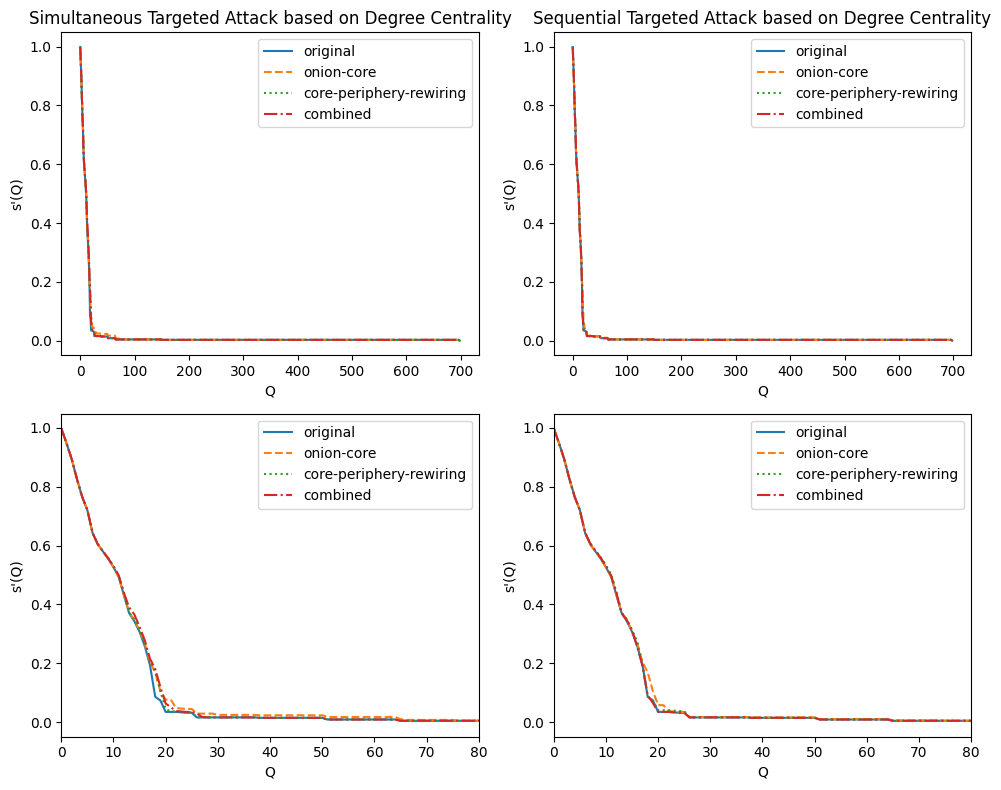

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Simultaneous
axs[0, 0].plot(r_sim, linestyle='-')
axs[0, 0].plot(r_1_sim, linestyle='--')
axs[0, 0].plot(r_2_sim, linestyle=':')
axs[0, 0].plot(r_3_sim, linestyle='-.')
axs[0, 0].legend(['original', 'onion-core', 'core-periphery-rewiring', 'combined'])
axs[0, 0].set_ylabel("s'(Q)")
axs[0, 0].set_xlabel('Q')
axs[0, 0].set_title('Simultaneous Targeted Attack based on Degree Centrality')

# Sequential
axs[0, 1].plot(r, linestyle='-')
axs[0, 1].plot(r_1, linestyle='--')
axs[0, 1].plot(r_2, linestyle=':')
axs[0, 1].plot(r_3, linestyle='-.')
axs[0, 1].legend(['original', 'onion-core', 'core-periphery-rewiring', 'combined'])
axs[0, 1].set_xlabel('Q')
axs[0, 1].set_ylabel("s'(Q)")
axs[0, 1].set_title('Sequential Targeted Attack based on Degree Centrality')

# Simultaneous
axs[1, 0].plot(r_sim, linestyle='-')
axs[1, 0].plot(r_1_sim, linestyle='--')
axs[1, 0].plot(r_2_sim, linestyle=':')
axs[1, 0].plot(r_3_sim, linestyle='-.')
axs[1, 0].legend(['original', 'onion-core', 'core-periphery-rewiring', 'combined'])
axs[1, 0].set_xlim(0, 80)
axs[1, 0].set_ylabel("s'(Q)")
axs[1, 0].set_xlabel('Q')

# Sequential
axs[1, 1].plot(r, linestyle='-')
axs[1, 1].plot(r_1, linestyle='--')
axs[1, 1].plot(r_2, linestyle=':')
axs[1, 1].plot(r_3, linestyle='-.')
axs[1, 1].legend(['original', 'onion-core', 'core-periphery-rewiring', 'combined'])
axs[1, 1].set_xlim(0, 80)
axs[1, 1].set_xlabel('Q')
axs[1, 1].set_ylabel("s'(Q)")

# Adjust layout, save and download the figure
plt.tight_layout()
plt.savefig('/content/robustness_plots.png')
plt.show()
from google.colab import files
files.download('/content/robustness_plots.png')
